In [1]:
import sys
import os
import glob
import time

import numpy as np
import matplotlib as mpl
import pylab as plt
import imageio 
import h5py
import json
import scipy
from skimage import filters, morphology, measure
from scipy.ndimage import binary_dilation, binary_erosion, binary_closing


from jetframegetter import JetFrameGetter
from jetanalysis import JetAnalysis
from regionprops import JetRegionProps
from plotjetdata import PlotJetData


from viewer import ImWin
import utils
import pyqtgraph as pg

import filters_playground as filt

%gui qt

In [2]:
# plt.style.use('dark_background')

This notebook serves as a playground for finding better nozzle tip finding methods! 

First, grab the data...

In [3]:
nozzle_id = "mh_coarse_b2_n1" #"mh_cut2_b4_n2"
basepath = "/Volumes/GoogleDrive/Shared drives/Kirian Lab/Small Data/mh_nozzles/20220609/"

config = {"data_path": os.path.join(basepath, nozzle_id),
            "save_path": os.path.join(basepath, nozzle_id, "analysis_kk"),
            }

all_data = np.sort(glob.glob(os.path.join(config['data_path'], "*.h5")))
# randmovie = np.random.randint(0,len(all_data))
all_data = all_data[53]#randmovie]


stack, metadata = utils.h5_metadata_version(all_data)
jetana = JetAnalysis(stack, metadata)


pstack = jetana.stack_processed # get the processed image stack
randframe = np.random.randint(0,len(pstack))

im = pstack[22]#randframe]

In [ ]:
# plt.style.use('dark_background')
plt.style.use('default')
ylim = [120,430]
fig, ax = plt.subplots(2,2, figsize=(8,3), dpi=200, tight_layout=True)
ax[0][0].imshow(jetana.image_stack_raw[22][:,ylim[0]:ylim[1]].T, cmap='gray')
ax[0][0].set_title("The Raw Image of the Jet", fontsize=12, fontweight="bold")
ax[0][1].imshow(jetana.stack_filtered[22][:,ylim[0]:ylim[1]].T, cmap='binary')
ax[0][1].set_title("Filtering Applied for Background Removal", fontsize=12, fontweight="bold")
ax[1][0].imshow(jetana.stack_thresholded[22][:,ylim[0]:ylim[1]].T, cmap='binary')
ax[1][0].set_title("Transformed to a Binary Image", fontsize=12, fontweight="bold")
ax[1][1].imshow(jetana.stack_processed[22][:,ylim[0]:ylim[1]].T, cmap='binary')
ax[1][1].set_title("Morphology Operations Applied", fontsize=12, fontweight="bold")

for i in [0,1]:
    for j in [0,1]:
#         ax[i,j].set_ylim(120,430)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    

In [ ]:
# method1 = ImWin(pstack)
# # method1.addItem(pg.InfiniteLine(ntip_idx))
# method1.display()

In [ ]:
# Useful functions:
def _find_longest_nonzero_subset(im):

        max_subset = []
        current_max_subset = []
        for i, n in enumerate(im):
            if n > 0:
                current_max_subset.append(i)
                if len(current_max_subset) > len(max_subset):
                    max_subset = current_max_subset
            else:
                current_max_subset = []
        return max_subset

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.imshow(im.T, cmap='binary')
ax.set_xlabel("Axis 1", fontsize=20)
ax.set_ylabel("Axis 0", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_title(f'Processed Image -- Video {randmovie}, Frame {randframe}');

# Method 1

In [ ]:
# plt.style.use(dark_background')
plt.style.use('default')

In [ ]:
x = np.sum(im, axis=1)
ntip_idx = np.where(x == np.max(x))[0]

In [ ]:
didx = _find_longest_nonzero_subset(x[:ntip_idx[0]])

In [ ]:
plt.figure()
plt.plot(x[:didx[0]])
plt.show()

In [1]:

figs, axs = plt.subplots(2,1, dpi=200, tight_layout=True, sharex=True)
for i in [0,1]:
    axs[i].axvspan(0, didx[0], alpha=0.1, color='green')
    axs[i].axvspan(didx[0], ntip_idx[0], alpha=0.1, color='blue')
    axs[i].axvspan(ntip_idx[0], 2000, alpha=0.1, color='red')
    
axs[0].imshow(im.T, cmap='binary')
axs[0].set_ylim(400,100)

axs[1].plot(x, color="k")
axs[1].set_ylim(100,-5)
for i in [0,1]:
    axs[i].set_xlim(0,1024)
    axs[i].vlines(ntip_idx[0], -20, 512, 'r', linestyle="--");
    axs[i].vlines(didx[0], -20, 512, 'g', linestyle="--");
    axs[i].set_xticks(np.arange(0,1024, 100))
    axs[i].grid(alpha=0.5, which='both')
figs.supxlabel("Axis 1", fontsize=15)
figs.supylabel("Axis 0", fontsize=15)
figs.suptitle("Image Projection Down Axis=0", fontsize=15);



NameError: name 'plt' is not defined

We can clearly see the three different regions. The droplets are between frames 0 and ~619, the jet is between ~610 and ~980, and the nozzle is between ~980 and 1024. Let's just use the peak as the reference, then.

In [ ]:
ntip_idx[0][0]

In [ ]:
ntip_idx = np.where(x == np.max(x))

In [ ]:
fig, ax = plt.subplots(1,1,dpi=150)
ax.imshow(im.T, cmap='binary')
ax.vlines(ntip_idx[0], 0, 512, 'r');

This method does a pretty good job and is very simple. The only downside is that it leave some of the nozzle tip in view, but that should be okay. The jet starts inside the nozzle tip, anyway, and as long as we're consistent it shouldn't matter that much.

# Method 2

Adding a fudge factor to method 1.

In [ ]:
x = np.sum(im, axis=1)
fudge = 5
ntip_idx = np.where(x == np.max(x))
ntip_idx = int(ntip_idx[0] - fudge)


In [ ]:
fig, ax = plt.subplots(1,1,dpi=150)
ax.imshow(im.T, cmap='gray')
ax.vlines(ntip_idx, 0, 512, 'r');

Alright, so we can get closer to the nozzle tip with some human intervention. But automation is key here, so this probably isn't the best way to go about finding the nozzle tip.

# Method 3

Cleaning up the image by removing pixels below a percentage of the jet breakup position.

In [ ]:
x = np.sum(im, axis=0)

In [ ]:
fig, ax = plt.subplots(dpi=150)
ax.plot(x)
ax.set_title("projection along axis=0");

Okay, so it's obvious where the jet is. You can even see where the nozzle tip should be, near y=0. For this to work, we need to introduce a fudge factor. What makes most sense here is to exclude everything that's outside of the jet region. 

In [ ]:
lim = 0.02 # fudge factor
lim = 0.9
xi = np.where(x < np.max(x) * (1-lim)) # find all the indices outside of this conditions
# print(xi[0])

In [ ]:
fig, ax = plt.subplots(dpi=150)
ax.imshow(im[:,xi[0]].T, cmap='gray') 
ax.set_title("projection along axis=0");

Looks like it finds the nozzle tip with no issue! Let's now find the proper index value. If we filter out the values above and sum across axis 1, we should see mainly zeros with one major spike at the nozzle tip.

In [ ]:
y = np.sum(im[:,xi[0]], axis=1)

In [ ]:
fig, ax = plt.subplots(dpi=150)
ax.plot(y)
ax.set_title("projection along axis=1");

As expected. We can either do a `np.where()` here to find the max, but that would introduce another fudge factor. To get it right on the nozzle tip, we can find the index values that has the longest nonzero subset along the x-axis. There's a function defined above that we'll use.

In [ ]:
xl = _find_longest_nonzero_subset(y) # get longest subset of nonzeros

This now grabs the range that corresponds to the nozzle only. From this, we can take the zeroth index, which should correspond to the nozzle tip.

In [ ]:
xl_idx = xl[0]

fig, ax = plt.subplots(dpi=150)
ax.imshow(im.T)
ax.vlines(xl_idx, 0, 512, 'r');

Right on the money! Let's tidy this up into a nice function and run it on the whole image stack.

In [ ]:
def _find_nozzle_tip_position(im, lim:float=0.9):
        x = np.sum(im, axis=0)
        xi = np.where(x < np.max(x) * (1-lim))
        a = np.sum(im[:,xi[0]], axis=1)
        ntip_idx = _find_longest_nonzero_subset(a)
        return ntip_idx[0]

In [ ]:
ntip_idx = []
for ims in pstack:
    idx = _find_nozzle_tip_position(ims)
    ntip_idx.append(idx)

In [ ]:
# Uncomment this stuff to see the pyqtgraph plots

method1 = ImWin(pstack)
method1.addItem(pg.InfiniteLine(ntip_idx))
method1.display()

# IDK how to add a line that moves for each frame.... 

## Question!

So what happens when you change the `lim` parameter?


In [ ]:
# lim = np.array([0.005, 0.05, 0.12, 0.25, 0.5, 1])
lim = np.array([1, 0.9, 0.8, 0.75, 0.7])

In [ ]:
ntip_idx = []
nsum = []
lims = []
a0 = []
x = np.sum(im, axis=0)
for li in lim:
    xi = np.where(x < np.max(x) * (1 - li))
    if len(xi[0]) == 0:
        continue
    lims.append(li)
    a = np.sum(im[:,xi[0]], axis=1)
    a0.append(a)
    nsum.append(xi)
    ntip_idx.append(_find_longest_nonzero_subset(a)[0])

In [ ]:
fig, ax = plt.subplots(len(ntip_idx),2, figsize=(20,25), tight_layout=True)
for i,li in enumerate(lims):
    ax[i][0].imshow(im.T, cmap='gray')
    ax[i][0].vlines(ntip_idx[i], 0, 512, 'r');
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    ax[i][0].set_ylabel(f"lim = {li:.02f}", fontsize=15)
        
    ax[i][1].plot(x[nsum[i]])
    
ax[0][0].set_title("Changing lim", fontsize=15)
ax[0][1].set_title("Sum Across Axis=1 of the New Nozzle Region", fontsize=15)
    
plt.show();

The position of the nozzle tip is highly dependent on this `lim` parameter. The least fudge factors and human intervention we have, the better. It's probably best to stick with method 1 so long as we note the nozzle tip position is slightly different than the location of the location of the calculated index. 

In [10]:
slope, yint

(-0.0446627429528807, 306.89649425646564)

[]

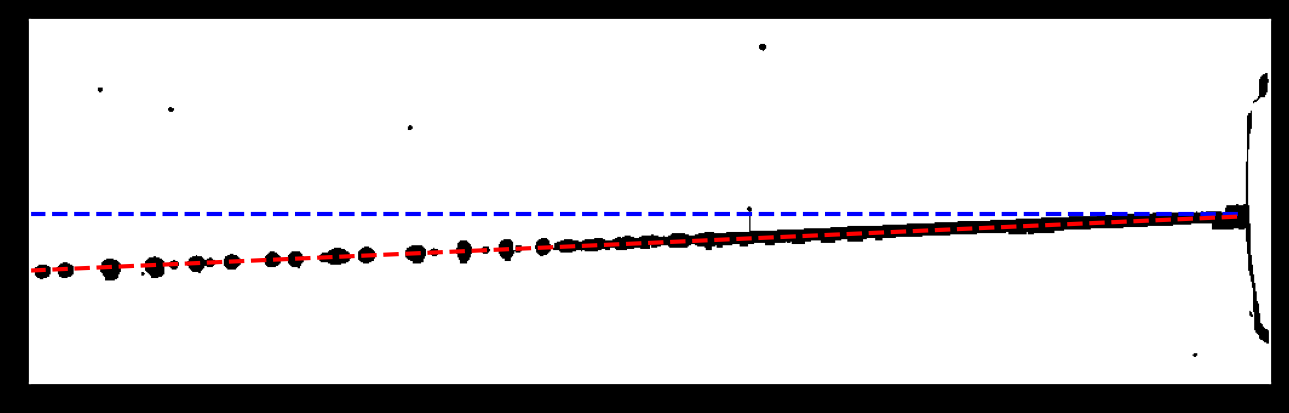

In [32]:
slope = np.mean(jetana._get_jet_fit[:,0])
yint = np.mean(jetana._get_jet_fit[:,1])

plt.style.use('dark_background')
# plt.style.use('default')
fig, ax = plt.subplots(1,1,figsize=(8,8),dpi=200)
ax.imshow(jetana.stack_processed[22].T, cmap='binary')
x = np.arange(1000)
li = slope * x + yint
ax.hlines(260, 0, 1000, linestyle='--', color='b')
ax.plot(x, li, '--r')
ax.set_ylim([400,100])
ax.set_yticks([])
ax.set_xticks([])
